In [1]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loaders.Loaders import CSVLoader
from splitters.splitters import SingletaskStratifiedSplitter
# from metrics.Metrics import Metric
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, matthews_corrcoef, precision_score)
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, Conv1D, Flatten, Reshape, LSTM, Bidirectional
# from models.kerasModels import KerasModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scalers.sklearnScalers import StandardScaler

import tensorflow as tf
print(tf.version.VERSION)

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings('ignore')

2.7.0


# CHECK GPU

Condition to check and enable GPU (Graphics Processing Unit) usage when training the deep learning models.

In [2]:
tf.config.experimental.list_physical_devices('GPU')

2022-01-26 14:52:06.196422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:52:06.202765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:52:06.203115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Using GPU: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Num GPUs Available:  1
Using GPU: /device:GPU:0


2022-01-26 14:52:06.212614: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 14:52:06.213283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:52:06.213731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:52:06.214134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Support functions

In [4]:
def metrics(label_test, predict):
    print('METRICS:')
    print(f"Accuracy score:\n{accuracy_score(label_test, predict)}\n")
    print(f"Recall score:\n{recall_score(label_test, predict, average='macro')}\n")
    print(f"Precison score:\n{precision_score(label_test, predict, average='macro', zero_division=0)}\n")
    print(f"F1-score:\n{f1_score(label_test, predict, average='macro')}\n")
    print(f"MCC score:\n{matthews_corrcoef(label_test, predict)}\n")
    print(f"Confusion matrix:\n{confusion_matrix(label_test, predict)}\n")
    print(f"Classification report:\n{classification_report(label_test, predict, zero_division=0, digits=3)}\n")

The ***metrics*** function receives the true labels for the test set and the labels predicted by the model, and it computes all the relevant metrics and the confusion matrix.
It also has an optional argument that indicates if we want to use regression or not. If we use regression, the function will show metrics only for regression.

Classification scores:
**Accuracy score**: Fraction of the prediction the model got right. The best value is 1, and the worst value is 0.
**Recall score**: The recall is the ability of the classifier to find all the positive samples. The best value is 1, and the worst value is 0.
**Precision score**: The precision is the ability of the classifier not to label as positive a sample that is negative. The best value is 1, and the worst value is 0.
**F1-score**: The F1 score can be interpreted as a harmonic mean of the precision and recall. The best value is 1, and the worst value is 0.
**MCC score**: Measure of the quality of binary and multiclass classifications. The MCC is, in essence, a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 is an average random prediction, and -1 is an inverse prediction.

In [5]:
early = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

Condiction the model uses when training that allows the training procedure to stop when the validation loss does not decrease on 5 consecutive epochs.

# Fingerprints

In [6]:
rdk_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/rdk_fs_all.csv'

bits = [0,5,25,34,36,55,77,78,101,103,105,106,113,117,128,129,142,175,188,194,195,196,197,200,203,211,231,270,274,278,281,291,309,335,365,382,386,388,400,406,411,419,427,438,443,461,471,492,498,515,516,522,532,549,563,586,589,594,608,620,632,636,640,668,671,674,676,684,697,701,704,707,719,728,734,738,742,759,779,791,798,799,838,841,847,853,857,865,870,876,883,887,927,935,940,955,962,972,985,992,1016,1024,1037,1043,1045,1051,1072,1097,1104,1113,1123,1130,1133,1134,1145,1155,1180,1184,1222,1238,1255,1265,1287,1288,1295,1302,1305,1338,1341,1342,1346,1347,1369,1374,1375,1377,1389,1400,1403,1420,1421,1451,1456,1472,1479,1483,1492,1494,1500,1501,1520,1522,1528,1533,1536,1542,1545,1548,1556,1579,1599,1605,1612,1652,1656,1667,1670,1672,1676,1681,1682,1685,1686,1699,1705,1707,1727,1732,1734,1771,1778,1792,1818,1820,1823,1832,1846,1849,1861,1867,1872,1876,1885,1889,1892,1915,1921,1931,1942,1971,1973,1992,1995,2003,2041]

str_bits = list(str(x) for x in bits)

In [7]:
loader = CSVLoader(rdk_path, mols_field='smiles', labels_fields='activity', features_fields=str_bits)

In [8]:
dataset = loader.create_dataset()
dataset.get_shape()

Mols_shape:  39990
Features_shape:  (39990, 205)
Labels_shape:  (39990,)


## Data Split

Split the data into train and test subsets. The training set contains 70% of the total data.

In [9]:
splitter = SingletaskStratifiedSplitter()
# train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset, frac_train=0.7)

input_dim = train_dataset.X.shape[1]

(27993, 205)
X not defined!
Defined features extracted!
(11997, 205)


## DNN

Dense Neural Network

In [10]:
dnn = Sequential()
dnn.add(Dense(126, input_dim=input_dim, activation='relu'))
dnn.add(Dropout(0.1))
dnn.add(Dense(64, activation='relu'))
dnn.add(Dropout(0.1))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))
# Compile model
dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

2022-01-26 14:52:08.127465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:52:08.127946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:52:08.128511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:52:08.128972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:52:08.129455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [11]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 126)               25956     
                                                                 
 dropout (Dropout)           (None, 126)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8128      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 35,141
Trainable params: 35,141
Non-traina

In [12]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_dnn = dnn.fit(train_dataset.X, train_dataset.y, validation_split=0.15, epochs=50, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/50
744/744 [==============================] - 3s 3ms/step - loss: 0.5872 - binary_accuracy: 0.6895 - val_loss: 0.7399 - val_binary_accuracy: 0.5768
Epoch 2/50
744/744 [==============================] - 2s 3ms/step - loss: 0.5272 - binary_accuracy: 0.7367 - val_loss: 0.9346 - val_binary_accuracy: 0.4415
Epoch 3/50
744/744 [==============================] - 2s 3ms/step - loss: 0.4869 - binary_accuracy: 0.7627 - val_loss: 0.6841 - val_binary_accuracy: 0.6494
Epoch 4/50
744/744 [==============================] - 2s 3ms/step - loss: 0.4551 - binary_accuracy: 0.7826 - val_loss: 0.7491 - val_binary_accuracy: 0.5909
Epoch 5/50
744/744 [==============================] - 2s 3ms/step - loss: 0.4213 - binary_accuracy: 0.8053 - val_loss: 0.6468 - val_binary_accuracy: 0.6840
Epoch 6/50
744/744 [==============================] - 3s 3ms/step - loss: 0.3930 - binary_accuracy: 0.8221 - val_loss: 0.6914 - val_binary_accuracy: 0.6649
Epoch 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


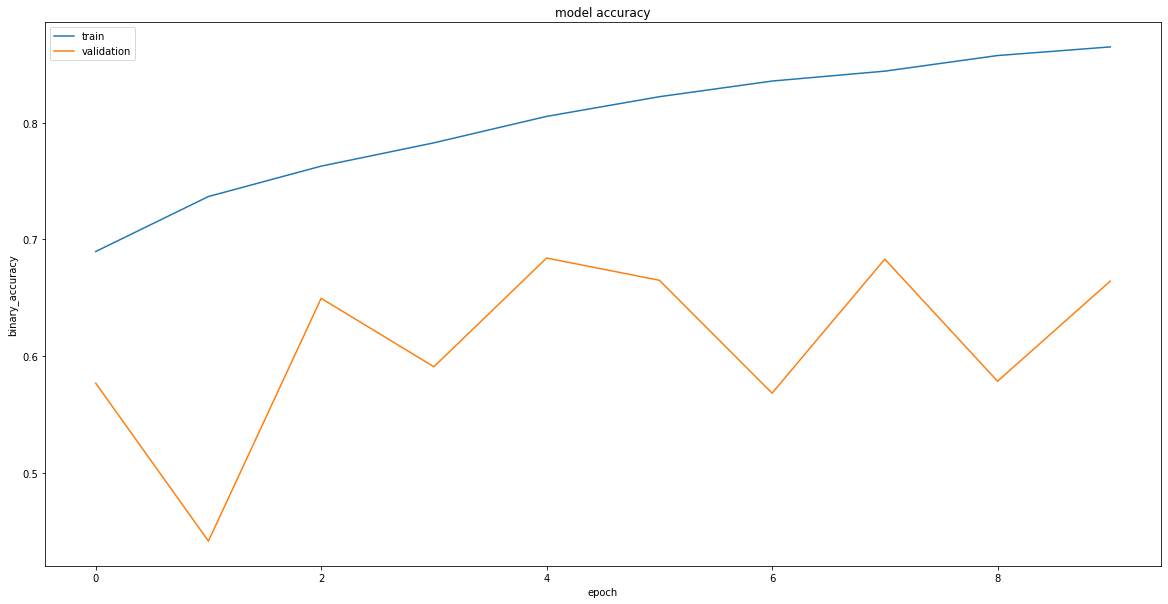

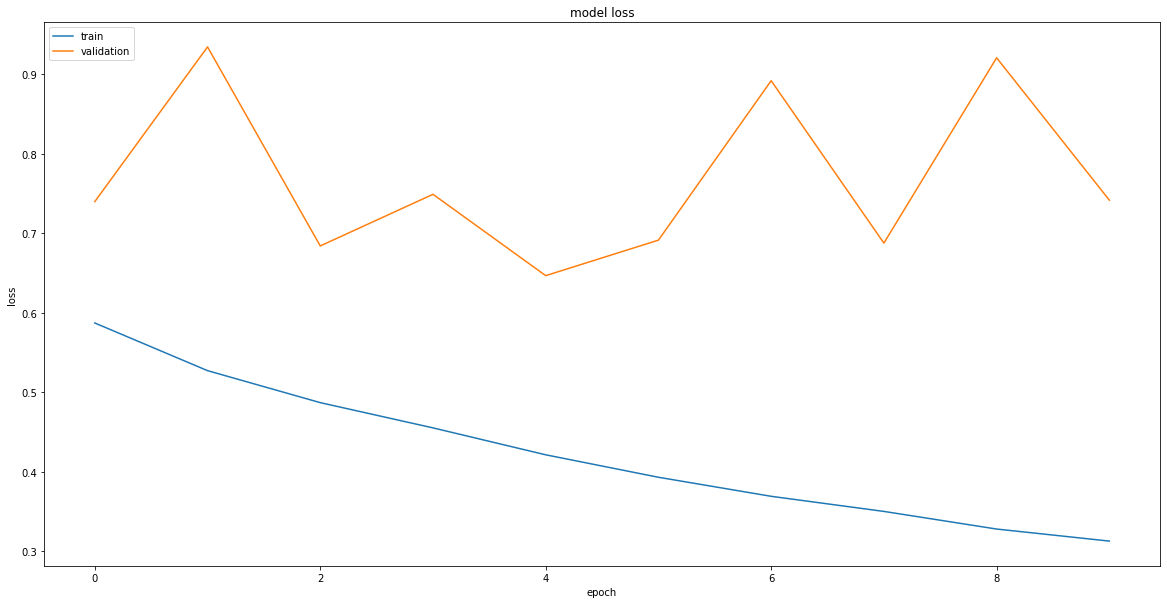

In [13]:
print(history_dnn.history.keys())
# summarize history for accuracy
plt.plot(history_dnn.history['binary_accuracy'])
plt.plot(history_dnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dnn.history['loss'])
plt.plot(history_dnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
pred_dnn = dnn.predict(test_dataset.X)

In [15]:
pred_dnn_bin= np.where(pred_dnn >= 0.50, 1,0)

In [16]:
metrics(test_dataset.y, pred_dnn_bin)

METRICS:
Accuracy score:
0.760190047511878

Recall score:
0.7601752959813239

Precison score:
0.7638562453301195

F1-score:
0.7593471741172527

MCC score:
0.5240186131247045

Confusion matrix:
[[4915 1085]
 [1792 4205]]

Classification report:
              precision    recall  f1-score   support

           0      0.733     0.819     0.774      6000
           1      0.795     0.701     0.745      5997

    accuracy                          0.760     11997
   macro avg      0.764     0.760     0.759     11997
weighted avg      0.764     0.760     0.759     11997




## CNN

Convolutional Neural Network

In [17]:
g_noise = 0.05
C1_K=8
C1_S=32
C2_K=16
C2_S=32

In [18]:
cnn = Sequential()
#Adding a bit of GaussianNoise also works as regularization
cnn.add(GaussianNoise(g_noise, input_shape=(input_dim,)))
#First two is number of filter + kernel size
cnn.add(Reshape((input_dim, 1)))
cnn.add(Conv1D(C1_K, (C1_S), activation='relu', padding="same"))
cnn.add(Conv1D(C2_K, (C2_S), padding="same", activation='relu'))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [19]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 205)              0         
 se)                                                             
                                                                 
 reshape (Reshape)           (None, 205, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 205, 8)            264       
                                                                 
 conv1d_1 (Conv1D)           (None, 205, 16)           4112      
                                                                 
 flatten (Flatten)           (None, 3280)              0         
                                                                 
 dropout_2 (Dropout)         (None, 3280)              0         
                                                      

In [20]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_cnn = cnn.fit(train_dataset.X, train_dataset.y, validation_split=0.15, epochs=50, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/50


2022-01-26 14:52:34.331269: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


744/744 [==============================] - 5s 5ms/step - loss: 0.5782 - binary_accuracy: 0.6970 - val_loss: 0.9015 - val_binary_accuracy: 0.4799
Epoch 2/50
744/744 [==============================] - 3s 4ms/step - loss: 0.5206 - binary_accuracy: 0.7440 - val_loss: 0.8887 - val_binary_accuracy: 0.4718
Epoch 3/50
744/744 [==============================] - 3s 4ms/step - loss: 0.4707 - binary_accuracy: 0.7746 - val_loss: 0.7914 - val_binary_accuracy: 0.5830
Epoch 4/50
744/744 [==============================] - 3s 4ms/step - loss: 0.4268 - binary_accuracy: 0.8031 - val_loss: 0.8510 - val_binary_accuracy: 0.5461
Epoch 5/50
744/744 [==============================] - 3s 4ms/step - loss: 0.3726 - binary_accuracy: 0.8327 - val_loss: 0.6584 - val_binary_accuracy: 0.6587
Epoch 6/50
744/744 [==============================] - 3s 4ms/step - loss: 0.3251 - binary_accuracy: 0.8607 - val_loss: 0.7433 - val_binary_accuracy: 0.6568
Epoch 7/50
744/744 [==============================] - 3s 4ms/step - loss: 0

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


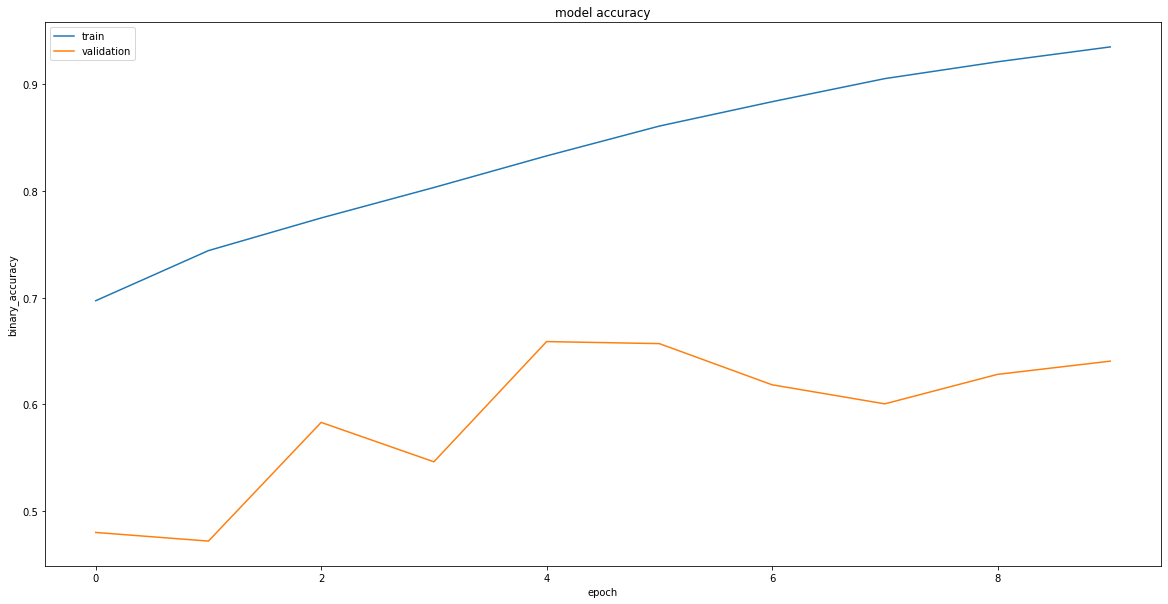

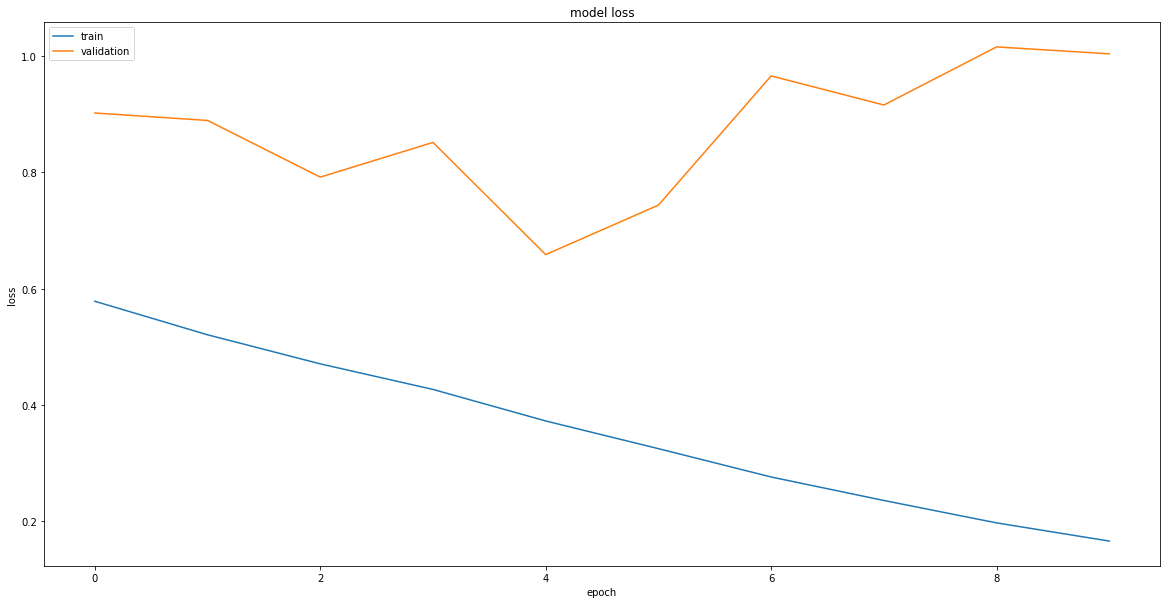

In [21]:
print(history_cnn.history.keys())
# summarize history for accuracy
plt.plot(history_cnn.history['binary_accuracy'])
plt.plot(history_cnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
pred_cnn = cnn.predict(test_dataset.X)

In [23]:
pred_cnn_bin = np.where(pred_cnn >= 0.50, 1, 0)

In [24]:
metrics(test_dataset.y, pred_cnn_bin)

METRICS:
Accuracy score:
0.7762774026840044

Recall score:
0.7762614223778556

Precison score:
0.7808593130393836

F1-score:
0.7753543950602222

MCC score:
0.5571017620088003

Confusion matrix:
[[5041  959]
 [1725 4272]]

Classification report:
              precision    recall  f1-score   support

           0      0.745     0.840     0.790      6000
           1      0.817     0.712     0.761      5997

    accuracy                          0.776     11997
   macro avg      0.781     0.776     0.775     11997
weighted avg      0.781     0.776     0.775     11997




## LSTM

Long Short-Term Memory. LSTM is a recurrent neural network.

In [25]:
x = np.reshape(train_dataset.X, (-1, 1, train_dataset.X.shape[1]))
y = np.reshape(train_dataset.y, (-1, 1, ))

In [26]:
xt = np.reshape(test_dataset.X, (-1, 1, test_dataset.X.shape[1]))
yt = np.reshape(test_dataset.y, (-1, 1, ))

In [27]:
x.shape

(27993, 1, 205)

In [28]:
y.shape

(27993, 1)

In [29]:
lstm = Sequential()
lstm.add(LSTM(128, input_shape=(x.shape[1], x.shape[2]), activation='relu', return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(64, return_sequences = True))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
# Compile model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [30]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            171008    
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_6 (Dense)             (None, 1, 128)            8320      
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 228,865
Trainable params: 228,865
Non-tr

In [31]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_lstm = lstm.fit(x, y, validation_split=0.15, epochs=50, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/50
744/744 [==============================] - 9s 8ms/step - loss: 0.5849 - binary_accuracy: 0.6919 - val_loss: 1.0856 - val_binary_accuracy: 0.3129
Epoch 2/50
744/744 [==============================] - 5s 7ms/step - loss: 0.5307 - binary_accuracy: 0.7326 - val_loss: 0.9088 - val_binary_accuracy: 0.4887
Epoch 3/50
744/744 [==============================] - 6s 7ms/step - loss: 0.4948 - binary_accuracy: 0.7552 - val_loss: 0.7907 - val_binary_accuracy: 0.5920
Epoch 4/50
744/744 [==============================] - 5s 7ms/step - loss: 0.4592 - binary_accuracy: 0.7803 - val_loss: 0.7328 - val_binary_accuracy: 0.6471
Epoch 5/50
744/744 [==============================] - 6s 8ms/step - loss: 0.4319 - binary_accuracy: 0.7966 - val_loss: 1.0197 - val_binary_accuracy: 0.4846
Epoch 6/50
744/744 [==============================] - 6s 7ms/step - loss: 0.4036 - binary_accuracy: 0.8143 - val_loss: 0.6848 - val_binary_accuracy: 0.6711
Epoch 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


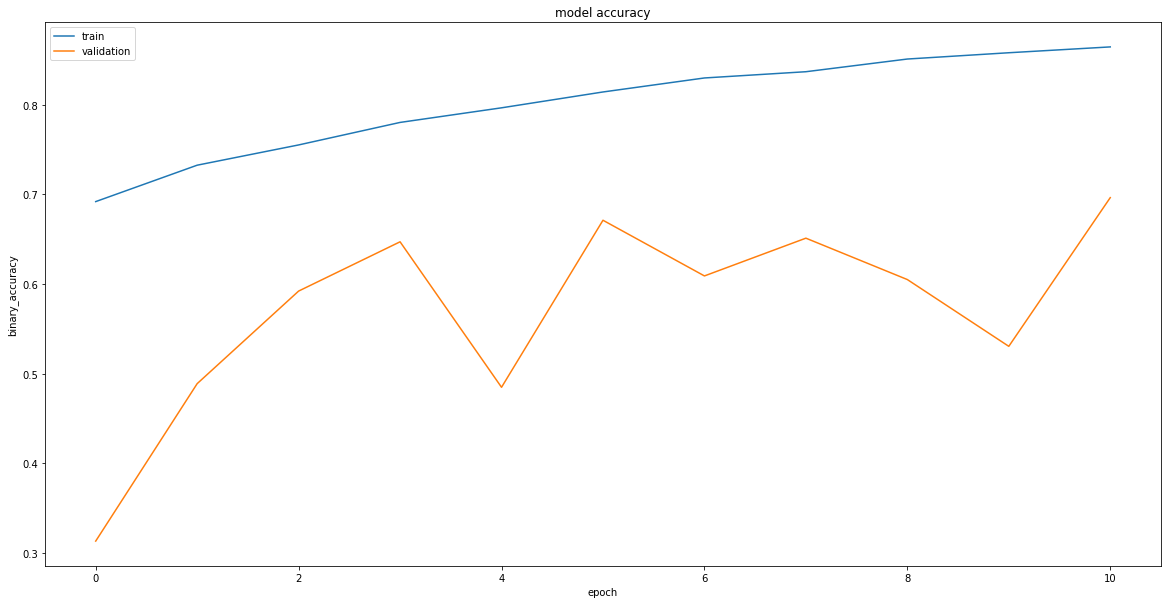

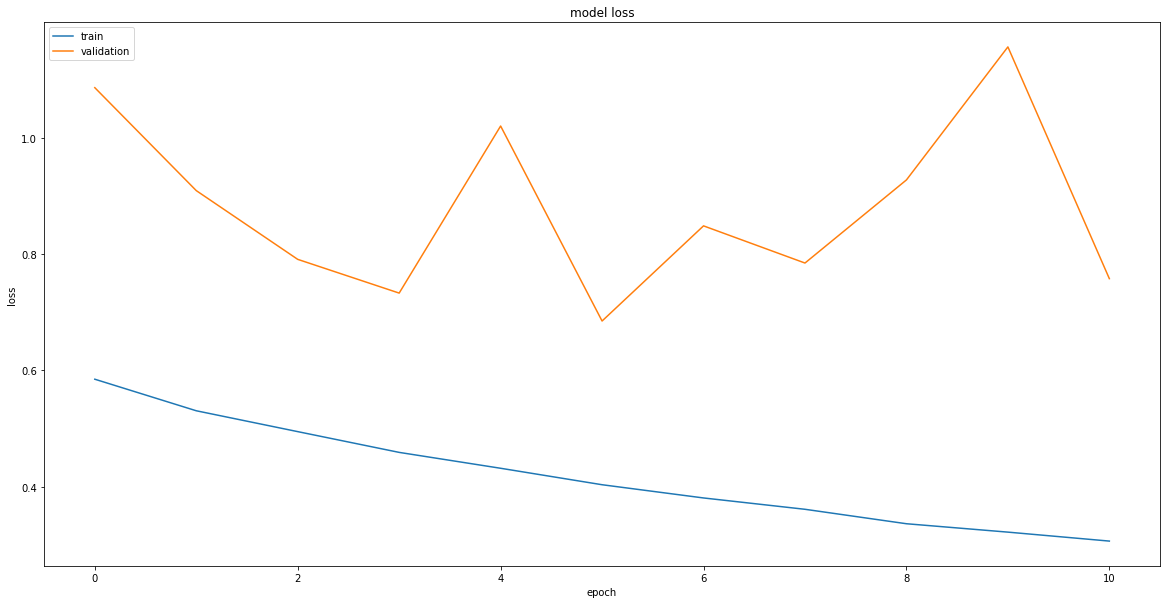

In [32]:
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['binary_accuracy'])
plt.plot(history_lstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
pred_lstm = lstm.predict(xt)

In [34]:
pred_lstm_bin = np.where(pred_lstm >= 0.50, 1, 0)

In [35]:
metrics(yt, pred_lstm_bin.flatten())

METRICS:
Accuracy score:
0.7721096940901893

Recall score:
0.7721029264632316

Precison score:
0.7729064920521355

F1-score:
0.7719402607740117

MCC score:
0.5450088261237637

Confusion matrix:
[[4795 1205]
 [1529 4468]]

Classification report:
              precision    recall  f1-score   support

           0      0.758     0.799     0.778      6000
           1      0.788     0.745     0.766      5997

    accuracy                          0.772     11997
   macro avg      0.773     0.772     0.772     11997
weighted avg      0.773     0.772     0.772     11997




## Bi-LSTM

Bidirectional Long Short-Term Memory

In [36]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(256, return_sequences = True), input_shape=(x.shape[1], x.shape[2])))
bilstm.add(Dropout(0.1))
bilstm.add(Bidirectional(LSTM(128, return_sequences = True)))
bilstm.add(Dropout(0.1))
bilstm.add(Bidirectional(LSTM(64, return_sequences = True)))
bilstm.add(Dropout(0.1))
bilstm.add(Dense(1, activation='sigmoid'))
# Compile model
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [37]:
bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 512)           946176    
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 1, 512)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           164352    
 nal)                                                            
                                                      

In [38]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_bilstm = bilstm.fit(x, y, validation_split=0.15, epochs=50, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/50
744/744 [==============================] - 19s 14ms/step - loss: 0.5827 - binary_accuracy: 0.6925 - val_loss: 0.8822 - val_binary_accuracy: 0.4656
Epoch 2/50
744/744 [==============================] - 7s 10ms/step - loss: 0.5274 - binary_accuracy: 0.7334 - val_loss: 0.6817 - val_binary_accuracy: 0.6404
Epoch 3/50
744/744 [==============================] - 7s 10ms/step - loss: 0.4723 - binary_accuracy: 0.7715 - val_loss: 0.7076 - val_binary_accuracy: 0.6240
Epoch 4/50
744/744 [==============================] - 7s 10ms/step - loss: 0.4266 - binary_accuracy: 0.8011 - val_loss: 0.6019 - val_binary_accuracy: 0.7247
Epoch 5/50
744/744 [==============================] - 7s 10ms/step - loss: 0.3773 - binary_accuracy: 0.8269 - val_loss: 0.9179 - val_binary_accuracy: 0.5535
Epoch 6/50
744/744 [==============================] - 8s 10ms/step - loss: 0.3351 - binary_accuracy: 0.8499 - val_loss: 0.8448 - val_binary_accuracy: 0.6213

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


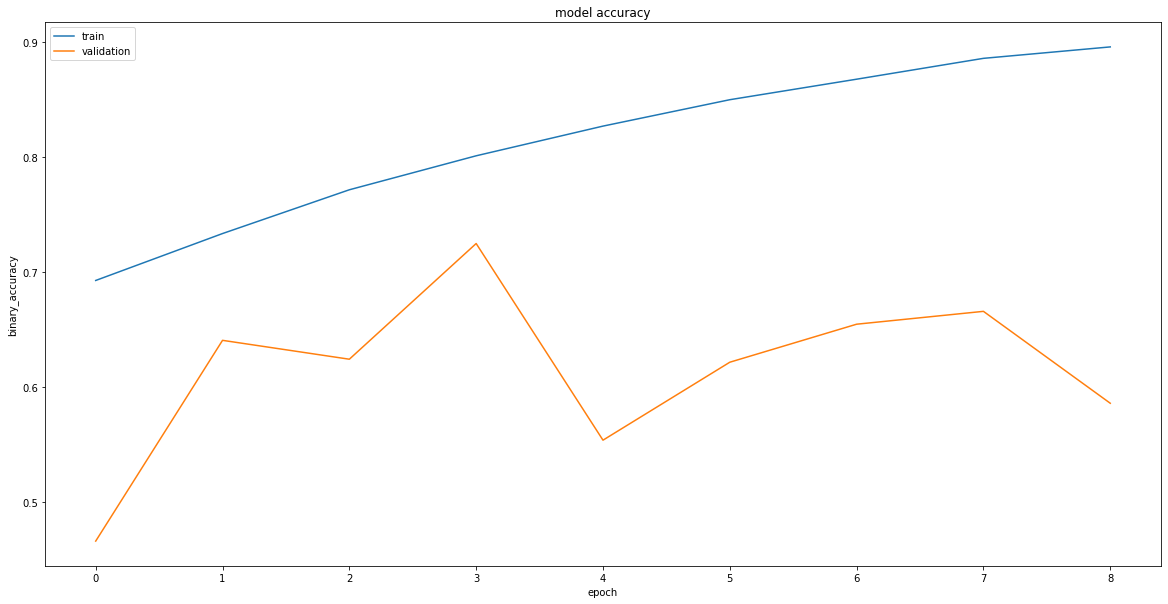

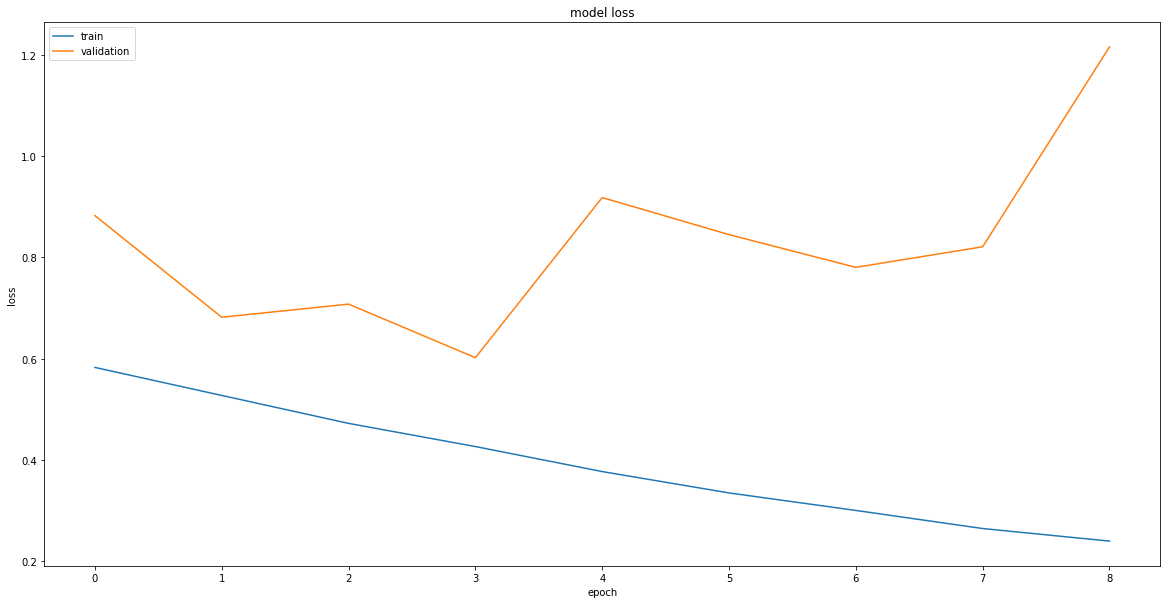

In [39]:
print(history_bilstm.history.keys())
# summarize history for accuracy
plt.plot(history_bilstm.history['binary_accuracy'])
plt.plot(history_bilstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
pred_bilstm = bilstm.predict(xt)

In [41]:
pred_bilstm_bin = np.where(pred_bilstm >= 0.50, 1, 0)

In [42]:
metrics(yt, pred_bilstm_bin.flatten())

METRICS:
Accuracy score:
0.7585229640743519

Recall score:
0.7584954143738536

Precison score:
0.7717022489062891

F1-score:
0.7555456238227145

MCC score:
0.5300331514814488

Confusion matrix:
[[5212  788]
 [2109 3888]]

Classification report:
              precision    recall  f1-score   support

           0      0.712     0.869     0.783      6000
           1      0.831     0.648     0.729      5997

    accuracy                          0.759     11997
   macro avg      0.772     0.758     0.756     11997
weighted avg      0.772     0.759     0.756     11997




## Results

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **DNN** | 0.760 | 0.760 | 0.764 | 0.759 | 0.524 |
| **CNN** | **0.776** | **0.776** | **0.781** | **0.775** | **0.557** |
| **LSTM** | 0.772 | 0.772 | 0.773 | 0.772 | 0.545 |
| **Bi-LSTM** | 0.759 | 0.758 | 0.772 | 0.756 | 0.530 |

Observing the metrics when predicting the test set labels, it is clear that the CNN model was the best at predicting the compound's activity using fingerprints.

# Descriptors

In [43]:
des_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/descriptors_all.csv'

des = ['MaxEStateIndex','MinEStateIndex','MaxAbsEStateIndex','MinAbsEStateIndex','qed','MolWt','HeavyAtomMolWt','ExactMolWt','NumValenceElectrons','NumRadicalElectrons','MaxPartialCharge','MinPartialCharge','MaxAbsPartialCharge','MinAbsPartialCharge','FpDensityMorgan1','FpDensityMorgan2','FpDensityMorgan3','BCUT2D_MWHI','BCUT2D_MWLOW','BCUT2D_CHGHI','BCUT2D_CHGLO','BCUT2D_LOGPHI','BCUT2D_LOGPLOW','BCUT2D_MRHI','BCUT2D_MRLOW','BalabanJ','BertzCT','Chi0','Chi0n','Chi0v','Chi1','Chi1n','Chi1v','Chi2n','Chi2v','Chi3n','Chi3v','Chi4n','Chi4v','HallKierAlpha','Ipc','Kappa1','Kappa2','Kappa3','LabuteASA','PEOE_VSA1','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','PEOE_VSA14','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','SMR_VSA1','SMR_VSA10','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA10','SlogP_VSA11','SlogP_VSA12','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','TPSA','EState_VSA1','EState_VSA10','EState_VSA11','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','VSA_EState1','VSA_EState10','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9','FractionCSP3','HeavyAtomCount','NHOHCount','NOCount','NumAliphaticCarbocycles','NumAliphaticHeterocycles','NumAliphaticRings','NumAromaticCarbocycles','NumAromaticHeterocycles','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','RingCount','MolLogP','MolMR','fr_Al_COO','fr_Al_OH','fr_Al_OH_noTert','fr_ArN','fr_Ar_COO','fr_Ar_N','fr_Ar_NH','fr_Ar_OH','fr_COO','fr_COO2','fr_C_O','fr_C_O_noCOO','fr_C_S','fr_HOCCN','fr_Imine','fr_NH0','fr_NH1','fr_NH2','fr_N_O','fr_Ndealkylation1','fr_Ndealkylation2','fr_Nhpyrrole','fr_SH','fr_aldehyde','fr_alkyl_carbamate','fr_alkyl_halide','fr_allylic_oxid','fr_amide','fr_amidine','fr_aniline','fr_aryl_methyl','fr_azide','fr_azo','fr_barbitur','fr_benzene','fr_benzodiazepine','fr_bicyclic','fr_diazo','fr_dihydropyridine','fr_epoxide','fr_ester','fr_ether','fr_furan','fr_guanido','fr_halogen','fr_hdrzine','fr_hdrzone','fr_imidazole','fr_imide','fr_isocyan','fr_isothiocyan','fr_ketone','fr_ketone_Topliss','fr_lactam','fr_lactone','fr_methoxy','fr_morpholine','fr_nitrile','fr_nitro','fr_nitro_arom','fr_nitro_arom_nonortho','fr_nitroso','fr_oxazole','fr_oxime','fr_para_hydroxylation','fr_phenol','fr_phenol_noOrthoHbond','fr_phos_acid','fr_phos_ester','fr_piperdine','fr_piperzine','fr_priamide','fr_prisulfonamd','fr_pyridine','fr_quatN','fr_sulfide','fr_sulfonamd','fr_sulfone','fr_term_acetylene','fr_tetrazole','fr_thiazole','fr_thiocyan','fr_thiophene','fr_unbrch_alkane','fr_urea']

des_loader = CSVLoader(des_path, mols_field='smiles', labels_fields='activity', features_fields=des)

In [44]:
des_dataset = des_loader.create_dataset()
des_dataset.get_shape()

Mols_shape:  39989
Features_shape:  (39989, 208)
Labels_shape:  (39989,)


## Standardize data

In [45]:
StandardScaler().fit_transform(des_dataset)

## Data split

In [46]:
splitter = SingletaskStratifiedSplitter()
des_train_dataset, des_test_dataset = splitter.train_test_split(dataset=des_dataset, frac_train=0.7)

des_input_dim = des_train_dataset.X.shape[1]

(27986, 208)
X not defined!
Defined features extracted!
(11994, 208)


## DNN

Dense Neural Network

In [47]:
dnn2 = Sequential()
dnn2.add(Dense(126, input_dim=des_input_dim, activation='relu'))
dnn2.add(Dropout(0.1))
dnn2.add(Dense(64, activation='relu'))
dnn2.add(Dropout(0.1))
dnn2.add(Dense(16, activation='relu'))
dnn2.add(Dense(1, activation='sigmoid'))
# Compile model
dnn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [48]:
dnn2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 126)               26334     
                                                                 
 dropout_8 (Dropout)         (None, 126)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8128      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 16)                1040      
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 35,519
Trainable params: 35,519
Non-trai

In [49]:
print(f'Train data size: {des_train_dataset.X.shape}\nTrain labels size: {des_train_dataset.y.shape}')
history_dnn2 = dnn2.fit(des_train_dataset.X, des_train_dataset.y, validation_split=0.15, epochs=50, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27986, 208)
Train labels size: (27986,)
Epoch 1/50
744/744 [==============================] - 3s 3ms/step - loss: 0.4894 - binary_accuracy: 0.7687 - val_loss: 0.5560 - val_binary_accuracy: 0.7087
Epoch 2/50
744/744 [==============================] - 2s 3ms/step - loss: 0.4372 - binary_accuracy: 0.7993 - val_loss: 0.5078 - val_binary_accuracy: 0.7301
Epoch 3/50
744/744 [==============================] - 2s 3ms/step - loss: 0.4168 - binary_accuracy: 0.8131 - val_loss: 0.6628 - val_binary_accuracy: 0.6444
Epoch 4/50
744/744 [==============================] - 2s 3ms/step - loss: 0.4020 - binary_accuracy: 0.8218 - val_loss: 0.5821 - val_binary_accuracy: 0.7184
Epoch 5/50
744/744 [==============================] - 2s 3ms/step - loss: 0.3891 - binary_accuracy: 0.8275 - val_loss: 0.5949 - val_binary_accuracy: 0.7006
Epoch 6/50
744/744 [==============================] - 2s 3ms/step - loss: 0.3718 - binary_accuracy: 0.8361 - val_loss: 0.6661 - val_binary_accuracy: 0.6606
Epoch 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


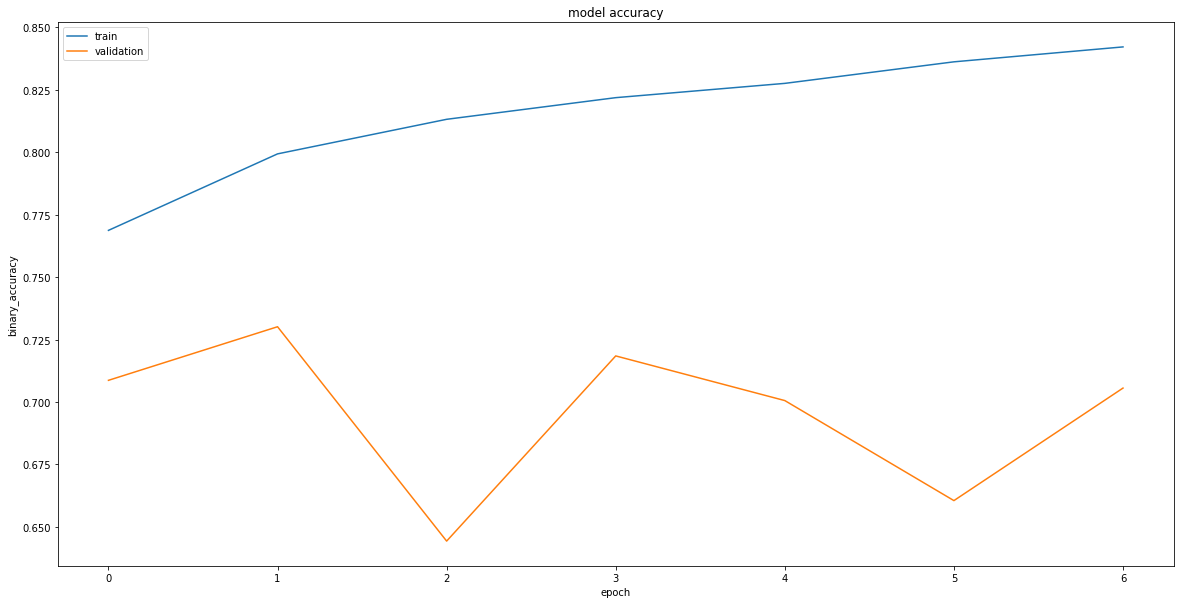

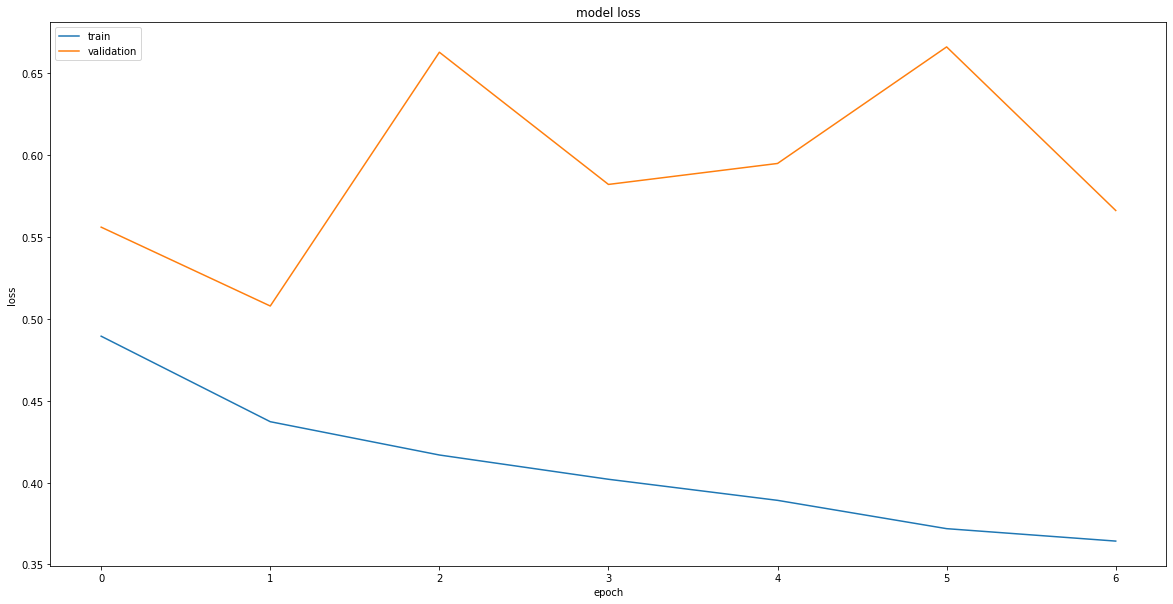

In [50]:
print(history_dnn2.history.keys())
# summarize history for accuracy
plt.plot(history_dnn2.history['binary_accuracy'])
plt.plot(history_dnn2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dnn2.history['loss'])
plt.plot(history_dnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [51]:
pred_dnn2 = dnn2.predict(des_test_dataset.X)

In [52]:
pred_dnn2_bin= np.where(pred_dnn2 >= 0.50, 1,0)

In [53]:
metrics(des_test_dataset.y, pred_dnn2_bin)

METRICS:
Accuracy score:
0.8068200767050192

Recall score:
0.8067827827827827

Precison score:
0.8137873052259632

F1-score:
0.8057286361586667

MCC score:
0.620530555892718

Confusion matrix:
[[5288  712]
 [1605 4389]]

Classification report:
              precision    recall  f1-score   support

           0      0.767     0.881     0.820      6000
           1      0.860     0.732     0.791      5994

    accuracy                          0.807     11994
   macro avg      0.814     0.807     0.806     11994
weighted avg      0.814     0.807     0.806     11994




## CNN

Convolutional Neural Network

In [54]:
g_noise = 0.05
C1_K=8
C1_S=32
C2_K=16
C2_S=32

In [55]:
cnn2 = Sequential()
#Adding a bit of GaussianNoise also works as regularization
cnn2.add(GaussianNoise(g_noise, input_shape=(des_input_dim,)))
#First two is number of filter + kernel size
cnn2.add(Reshape((des_input_dim, 1)))
cnn2.add(Conv1D(C1_K, (C1_S), activation='relu', padding="same"))
cnn2.add(Conv1D(C2_K, (C2_S), padding="same", activation='relu'))
cnn2.add(Flatten())
cnn2.add(Dropout(0.2))
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))
cnn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [56]:
cnn2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (GaussianN  (None, 208)              0         
 oise)                                                           
                                                                 
 reshape_1 (Reshape)         (None, 208, 1)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 208, 8)            264       
                                                                 
 conv1d_3 (Conv1D)           (None, 208, 16)           4112      
                                                                 
 flatten_1 (Flatten)         (None, 3328)              0         
                                                                 
 dropout_10 (Dropout)        (None, 3328)              0         
                                                      

In [57]:
print(f'Train data size: {des_train_dataset.X.shape}\nTrain labels size: {des_train_dataset.y.shape}')
history_cnn2 = cnn2.fit(des_train_dataset.X, des_train_dataset.y, validation_split=0.15, epochs=50, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27986, 208)
Train labels size: (27986,)
Epoch 1/50
744/744 [==============================] - 4s 5ms/step - loss: 0.4807 - binary_accuracy: 0.7741 - val_loss: 0.6160 - val_binary_accuracy: 0.6684
Epoch 2/50
744/744 [==============================] - 3s 4ms/step - loss: 0.4251 - binary_accuracy: 0.8057 - val_loss: 0.5890 - val_binary_accuracy: 0.7030
Epoch 3/50
744/744 [==============================] - 3s 4ms/step - loss: 0.3884 - binary_accuracy: 0.8272 - val_loss: 0.5619 - val_binary_accuracy: 0.7065
Epoch 4/50
744/744 [==============================] - 3s 4ms/step - loss: 0.3537 - binary_accuracy: 0.8456 - val_loss: 0.6518 - val_binary_accuracy: 0.6672
Epoch 5/50
744/744 [==============================] - 3s 4ms/step - loss: 0.3172 - binary_accuracy: 0.8654 - val_loss: 0.5547 - val_binary_accuracy: 0.7265
Epoch 6/50
744/744 [==============================] - 3s 4ms/step - loss: 0.2789 - binary_accuracy: 0.8835 - val_loss: 0.5903 - val_binary_accuracy: 0.7199
Epoch 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


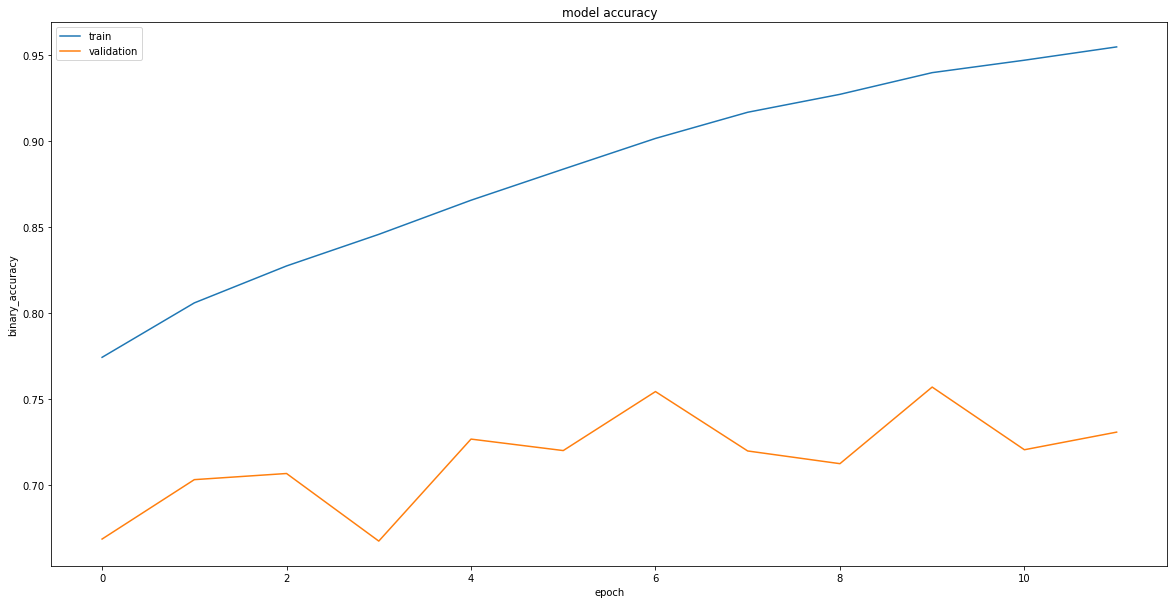

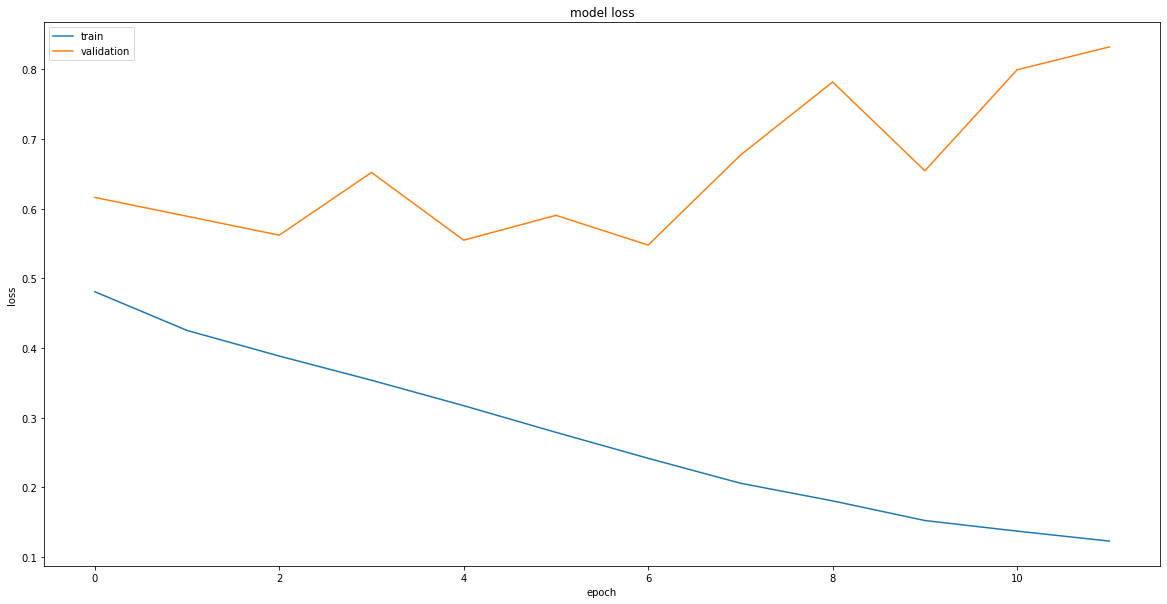

In [58]:
print(history_cnn2.history.keys())
# summarize history for accuracy
plt.plot(history_cnn2.history['binary_accuracy'])
plt.plot(history_cnn2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn2.history['loss'])
plt.plot(history_cnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [59]:
pred_cnn2 = cnn2.predict(des_test_dataset.X)

In [60]:
pred_cnn2_bin = np.where(pred_cnn2 >= 0.50, 1, 0)

In [61]:
metrics(des_test_dataset.y, pred_cnn2_bin)

METRICS:
Accuracy score:
0.8173253293313323

Recall score:
0.8172951284617951

Precison score:
0.8220143797433035

F1-score:
0.8166479800623194

MCC score:
0.6392920896967106

Confusion matrix:
[[5266  734]
 [1457 4537]]

Classification report:
              precision    recall  f1-score   support

           0      0.783     0.878     0.828      6000
           1      0.861     0.757     0.806      5994

    accuracy                          0.817     11994
   macro avg      0.822     0.817     0.817     11994
weighted avg      0.822     0.817     0.817     11994




## LSTM

Long Short-Term Memory. LSTM is a recurrent neural network.

### Reshape data

In [62]:
xx = np.reshape(des_train_dataset.X, (-1, 1, des_train_dataset.X.shape[1]))
yy = np.reshape(des_train_dataset.y, (-1, 1,))
xxt = np.reshape(des_test_dataset.X, (-1, 1, des_test_dataset.X.shape[1]))
yyt = np.reshape(des_test_dataset.y, (-1, 1,))

In [63]:
xx.shape

(27986, 1, 208)

In [64]:
yy.shape

(27986, 1)

In [65]:
lstm2 = Sequential()
lstm2.add(LSTM(128, input_shape=(xx.shape[1], xx.shape[2]), activation='relu', return_sequences=True))
lstm2.add(Dropout(0.2))
lstm2.add(LSTM(64, return_sequences=True))
lstm2.add(Dense(128, activation='relu'))
lstm2.add(Dropout(0.2))
lstm2.add(Dense(1, activation='sigmoid'))
# Compile model
lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [66]:
lstm2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 128)            172544    
                                                                 
 dropout_11 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_15 (Dense)            (None, 1, 128)            8320      
                                                                 
 dropout_12 (Dropout)        (None, 1, 128)            0         
                                                                 
 dense_16 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 230,401
Trainable params: 230,401
Non-tr

In [67]:
print(f'Train data size: {xx.shape}\nTrain labels size: {yy.shape}')
history_lstm2 = lstm2.fit(xx, yy, validation_split=0.15, epochs=50, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27986, 1, 208)
Train labels size: (27986, 1)
Epoch 1/50
744/744 [==============================] - 9s 9ms/step - loss: 0.4718 - binary_accuracy: 0.7811 - val_loss: 0.5674 - val_binary_accuracy: 0.7294
Epoch 2/50
744/744 [==============================] - 6s 7ms/step - loss: 0.4166 - binary_accuracy: 0.8107 - val_loss: 0.4668 - val_binary_accuracy: 0.7825
Epoch 3/50
744/744 [==============================] - 6s 8ms/step - loss: 0.3844 - binary_accuracy: 0.8312 - val_loss: 0.5629 - val_binary_accuracy: 0.7168
Epoch 4/50
744/744 [==============================] - 6s 8ms/step - loss: 0.3655 - binary_accuracy: 0.8382 - val_loss: 0.5500 - val_binary_accuracy: 0.7268
Epoch 5/50
744/744 [==============================] - 6s 8ms/step - loss: 0.3457 - binary_accuracy: 0.8485 - val_loss: 0.5151 - val_binary_accuracy: 0.7632
Epoch 6/50
744/744 [==============================] - 6s 7ms/step - loss: 0.3271 - binary_accuracy: 0.8609 - val_loss: 0.5299 - val_binary_accuracy: 0.7542
E

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


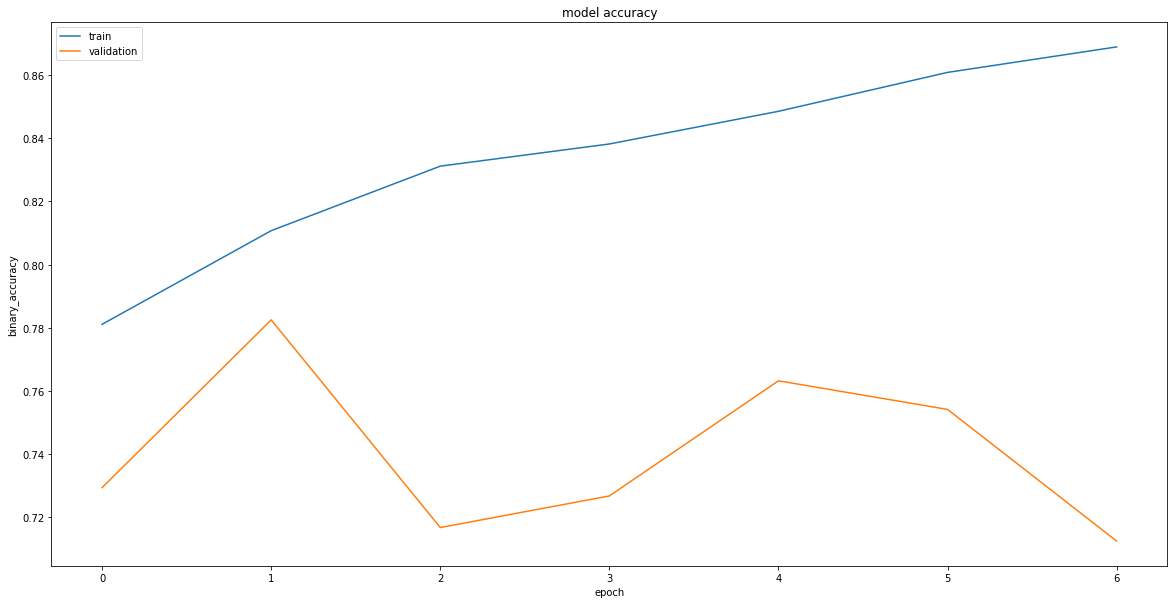

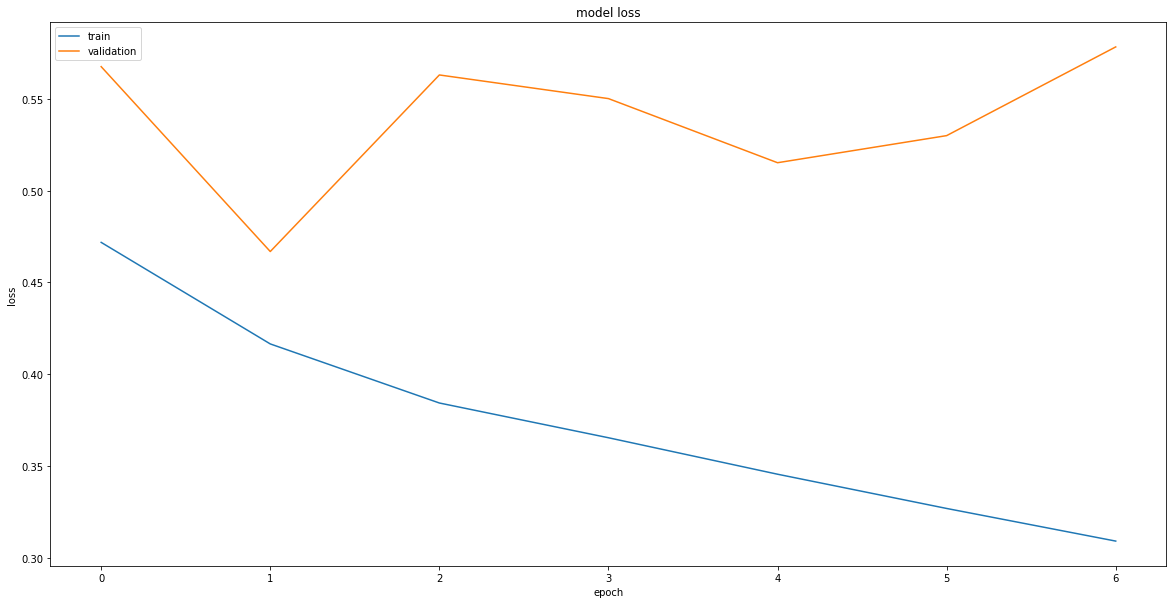

In [68]:
print(history_lstm2.history.keys())
# summarize history for accuracy
plt.plot(history_lstm2.history['binary_accuracy'])
plt.plot(history_lstm2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm2.history['loss'])
plt.plot(history_lstm2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [69]:
pred_lstm2 = lstm2.predict(xxt)

In [70]:
pred_lstm2_bin = np.where(pred_lstm2 >= 0.50, 1, 0)

In [71]:
metrics(yyt, pred_lstm2_bin.flatten())

METRICS:
Accuracy score:
0.8114890778722694

Recall score:
0.8114473640306974

Precison score:
0.8203916303787714

F1-score:
0.8101561687991413

MCC score:
0.6317756840492228

Confusion matrix:
[[5369  631]
 [1630 4364]]

Classification report:
              precision    recall  f1-score   support

           0      0.767     0.895     0.826      6000
           1      0.874     0.728     0.794      5994

    accuracy                          0.811     11994
   macro avg      0.820     0.811     0.810     11994
weighted avg      0.820     0.811     0.810     11994




## Bi-LSTM

Bidirectional Long Short-Term Memory

In [72]:
bilstm2 = Sequential()
bilstm2.add(Bidirectional(LSTM(256, return_sequences = True), input_shape=(xx.shape[1], xx.shape[2])))
bilstm2.add(Dropout(0.1))
bilstm2.add(Bidirectional(LSTM(128, return_sequences = True)))
bilstm2.add(Dropout(0.1))
bilstm2.add(Bidirectional(LSTM(64, return_sequences = True)))
bilstm2.add(Dropout(0.1))
bilstm2.add(Dense(1, activation='sigmoid'))
# Compile model
bilstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [73]:
bilstm2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 1, 512)           952320    
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 1, 256)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 1, 128)           164352    
 nal)                                                            
                                                      

In [74]:
print(f'Train data size: {xx.shape}\nTrain labels size: {yy.shape}')
history_bilstm2 = bilstm2.fit(xx, yy, validation_split=0.15, epochs=50, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27986, 1, 208)
Train labels size: (27986, 1)
Epoch 1/50
744/744 [==============================] - 17s 12ms/step - loss: 0.4631 - binary_accuracy: 0.7874 - val_loss: 0.5944 - val_binary_accuracy: 0.6972
Epoch 2/50
744/744 [==============================] - 7s 10ms/step - loss: 0.4065 - binary_accuracy: 0.8164 - val_loss: 0.5245 - val_binary_accuracy: 0.7253
Epoch 3/50
744/744 [==============================] - 7s 10ms/step - loss: 0.3706 - binary_accuracy: 0.8358 - val_loss: 0.6266 - val_binary_accuracy: 0.7280
Epoch 4/50
744/744 [==============================] - 7s 10ms/step - loss: 0.3329 - binary_accuracy: 0.8564 - val_loss: 0.5399 - val_binary_accuracy: 0.7287
Epoch 5/50
744/744 [==============================] - 7s 10ms/step - loss: 0.2986 - binary_accuracy: 0.8721 - val_loss: 0.6907 - val_binary_accuracy: 0.6837
Epoch 6/50
744/744 [==============================] - 7s 10ms/step - loss: 0.2625 - binary_accuracy: 0.8870 - val_loss: 0.6153 - val_binary_accuracy: 0

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


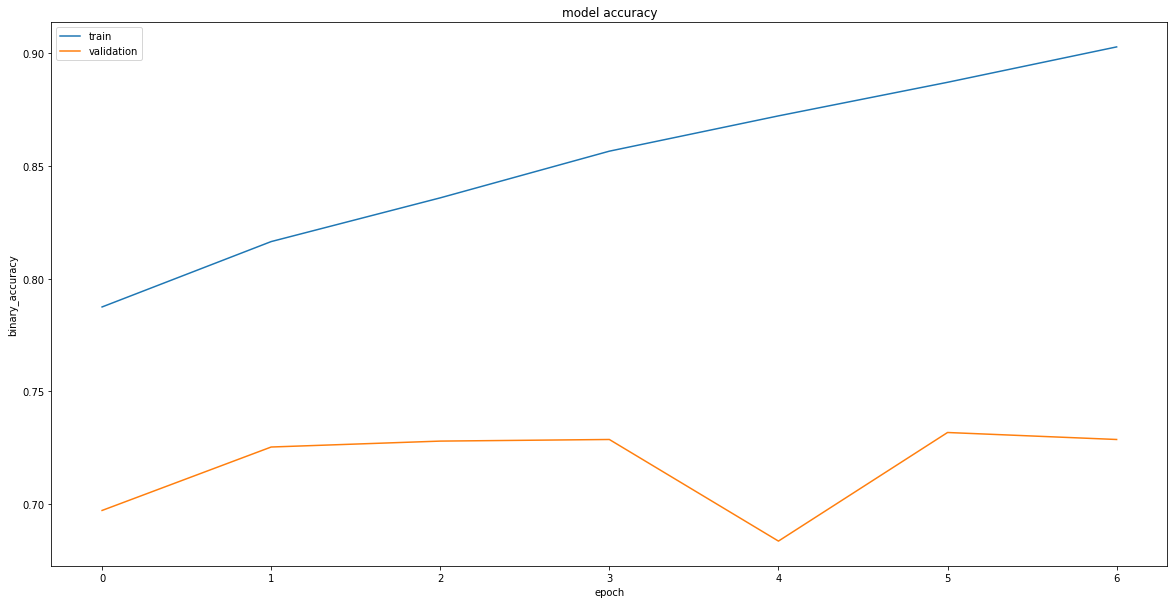

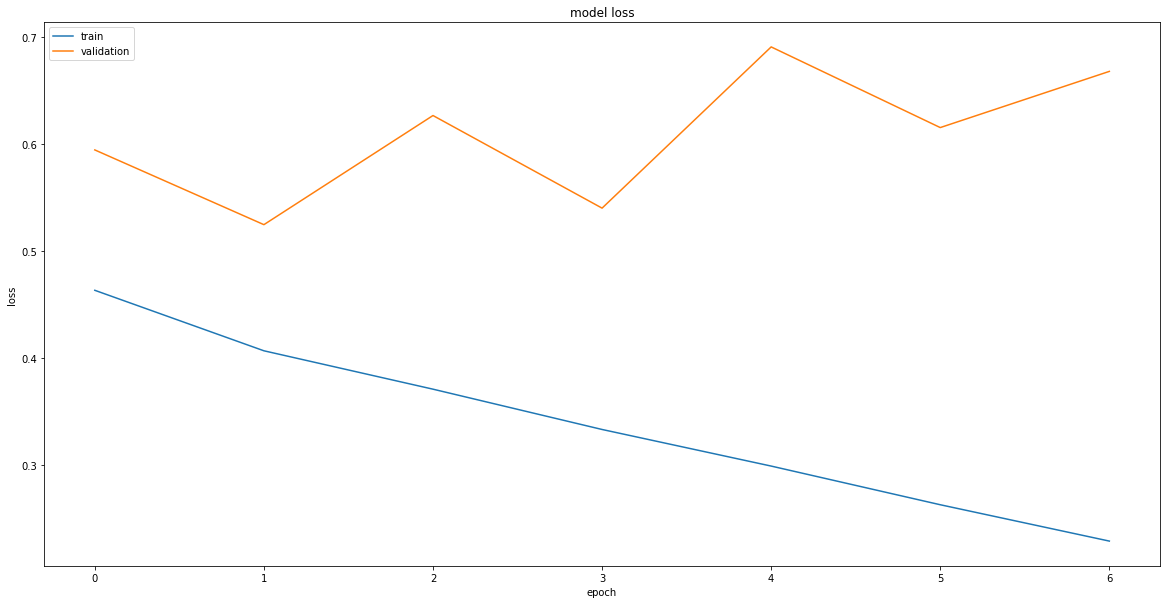

In [75]:
print(history_bilstm2.history.keys())
# summarize history for accuracy
plt.plot(history_bilstm2.history['binary_accuracy'])
plt.plot(history_bilstm2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bilstm2.history['loss'])
plt.plot(history_bilstm2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [76]:
pred_bilstm2 = bilstm2.predict(xxt)

In [77]:
pred_bilstm2_bin = np.where(pred_bilstm2 >= 0.50, 1, 0)

In [78]:
metrics(yyt, pred_bilstm2_bin.flatten())

METRICS:
Accuracy score:
0.8199933299983325

Recall score:
0.819963046379713

Precison score:
0.8247486279077807

F1-score:
0.8193221925434516

MCC score:
0.6446939127772354

Confusion matrix:
[[5283  717]
 [1442 4552]]

Classification report:
              precision    recall  f1-score   support

           0      0.786     0.880     0.830      6000
           1      0.864     0.759     0.808      5994

    accuracy                          0.820     11994
   macro avg      0.825     0.820     0.819     11994
weighted avg      0.825     0.820     0.819     11994




## Results

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **DNN** | 0.807 | 0.807 | 0.814 | 0.806 | 0.621 |
| **CNN** | 0.817 | 0.817 | 0.822 | 0.817 | 0.639 |
| **LSTM** | 0.811 | 0.811 | 0.820 | 0.810 | 0.632 |
| **Bi-LSTM** | **0.820** | **0.820** | **0.825** | **0.820** | **0.645** |

Observing the metrics when predicting the test set labels, it is clear that the Bi-LSTM model was the best at predicting the compound's activity using descriptors.

# Conclusion

| Data | Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Fingerprints** | CNN | 0.776 | 0.776 | 0.781 | 0.775 | 0.557 |
| **Descriptors** | **Bi-LSTM** | **0.820** | **0.820** | **0.825** | **0.820** | **0.645** |

Following these results, descriptors where the best at predicting the coumpound's activity with a accuracy improvment of 5% over the fingerprints accuracy. However, it is visible from the training and validation loss graphs that all models appear to suffer a bit of overfit. The training loss is constantly tending to zero, which is expected, but the validation loss often follows a zig-zag pattern with a tendency to rise. This is a sign that the model is overfitting the training set.